# Building-levels Deltas of Energy Performance

**Author:** Kiki Mei  
**Date:** October 21, 2025    
**Data Source:** Chicago Energy Benchmarking Dataset (2014-2023) - City of Chicago Open Data Portal  

## Section 1: Data Set up

We will use the concurrent_buildings defined in utils/data_utils.py to help track the building IDs appears constantly across the specific range and filter out the dataframe from the original dataset energy_data. The default data setting is period 2016-2023.

In [6]:
# Standard library imports
import sys

# Add utils folder to Python path
sys.path.append("../utils")

# load in local helper functions
from data_utils import concurrent_buildings, load_data, pivot_energy_metric

In [2]:
import matplotlib.pyplot as plt

# Load the data loader function
data = load_data()
energy_data = concurrent_buildings(data, 2016, 2023)

# Print basic information
print(
    f"Loaded dataset with {energy_data.shape[0]:,} rows and {energy_data.shape[1]} columns."
)
energy_data.head()

Loaded dataset with 18,904 rows and 30 columns.


,Data Year,ID,Property Name,Address,ZIP Code,Community Area,Primary Property Type,Gross Floor Area - Buildings (sq ft),Year Built,# of Buildings,...,Total GHG Emissions (Metric Tons CO2e),GHG Intensity (kg CO2e/sq ft),Latitude,Longitude,Location,Reporting Status,Chicago Energy Rating,Exempt From Chicago Energy Rating,Water Use (kGal),Row_ID
24486,2016,116336,lasalle private residences,1212 N LaSalle,60610,near north side,multifamily housing,367627.0,1986.0,1.0,...,2575.3,7.0,41.904201,-87.633825,point (-87.63382507 41.90420084),nan,NaN,nan,NaN,nan
24496,2016,101745,161 north clark,161 North Clark,60601,loop,office,1200836.0,1992.0,1.0,...,15498.4,12.9,41.884905,-87.630518,point (-87.6305179 41.88490511),nan,NaN,nan,NaN,nan
24495,2016,101448,1401 w roosevelt - 2017 resubmit,1401 W. Roosevelt,60608,near west side,multifamily housing,69385.0,2006.0,1.0,...,242.4,3.5,41.849153,-87.670896,point (-87.67089596 41.84915346),nan,NaN,nan,NaN,nan
24494,2016,159892,promontory corporation,5530-5532 S Shore Drive,60637,hyde park,multifamily housing,180351.0,1949.0,1.0,...,1317.3,7.3,41.794687,-87.580465,point (-87.58046479 41.794687),nan,NaN,nan,NaN,nan
24493,2016,103602,190 south lasalle,190 South LaSalle,60603,loop,office,882560.0,1985.0,1.0,...,11519.9,13.1,41.879756,-87.632687,point (-87.63268685 41.8797561),nan,NaN,nan,NaN,nan


Then we will see the occurrences of each buildings (identified by the Building IDs) through out the chronological scale.

In [3]:
# Count how many years each building appears in
building_year_counts = energy_data.groupby("ID")["Data Year"].nunique().reset_index()
building_year_counts = building_year_counts[building_year_counts["Data Year"] > 1]
building_year_counts = building_year_counts.sort_values(by="Data Year", ascending=False)

print(f"Buildings with multiple years of data: {len(building_year_counts)}")
building_year_counts

Buildings with multiple years of data: 2363


,ID,Data Year
0,100001,8
1587,250073,8
1571,250051,8
1572,250052,8
1573,250053,8
...,...,...
788,157618,8
789,157767,8
790,157832,8
791,157887,8


Getting the filtered buildings, we could track the key metrics for each building to see how the energy performance changes over the period of time, with a event split at 2019 (Chicago Energy Rating Placards introduced).

To have closer look at the composition of property in each data subset, we group the building IDs by the Primary Property Type.

In [5]:
energy_data = energy_data[
    energy_data["Primary Property Type"].notna()
    & (energy_data["Primary Property Type"].str.lower() != "nan")
]
print(energy_data.shape)

energy_data.groupby("Primary Property Type")["ID"].nunique().reset_index().sort_values(
    by="ID", ascending=False
).head(15)

(17298, 30)


,Primary Property Type,ID
23,multifamily housing,1173
15,k-12 school,379
27,office,313
43,residential,120
3,college/university,75
13,hotel,67
46,senior care community,52
45,retail store,51
47,senior living community,48
50,supermarket/grocery store,48


## Section 2: Generate Building Tendency over time

Now, with the cleaned dataset of consistant buildings, we could start to analyze the tendency of key metrics of energy performance at building-levels. Key metrics would include: Electricity Use (kBtu), Natural Gas Use (kBtu), District Steam Use (kBtu), GHG Intensity (kg CO2e/sq ft), Site EUI (kBtu/sq ft), Source EUI (kBtu/sq ft), Weather Normalized Site EUI (kBtu/sq ft), or Weather Normalized Source EUI (kBtu/sq ft). 

But just for exploration, we will pick four of them: Electricity Use (kBtu), GHG Intensity (kg CO2e/sq ft), Site EUI (kBtu/sq ft), Source EUI (kBtu/sq ft).

We will use pivot_energy_metric in utils/data_utils.py to create the pivot dataframe for the specific metrics of energy performance that we're interested at building-levels.    
**The method pivot_energy_metric has dropped rows with null values in the specific year range the buildings consistantly appeared. So the number of rows should be less than the dataframe energy_10 (208 buildings) and energy_8 (2041 buildings).**

### 2.1：Site EUI (kBtu/sq ft)

In [9]:
# Site EUI over 8-years buildings (2016-2023)
site_eui = pivot_energy_metric(metric_col="Site EUI (kBtu/sq ft)", input_df=energy_data)
print(site_eui.shape)
site_eui.head()

(1223, 8)


Data Year,2016,2017,2018,2019,2020,2021,2022,2023
ID,,,,,,,,
100001,190.4,182.6,188.8,178.3,175.0,171.0,164.0,162.5
100068,94.2,85.2,78.9,81.3,58.9,91.4,108.3,81.7
100346,36.0,62.2,53.2,48.8,42.8,56.4,43.9,41.1
100375,28.1,95.6,67.4,64.8,89.0,82.8,82.3,93.0
100393,239.1,226.8,172.6,144.1,151.4,157.5,27.1,27.1


First we could explore the average Site EUI changes over time.

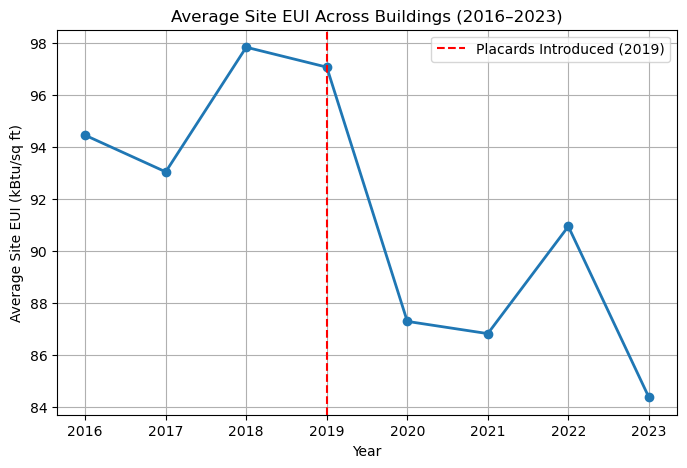

In [10]:
# annual average Site EUI across all buildings appear in 2016-2023
mean_eui = site_eui.mean(axis=0)

plt.figure(figsize=(8, 5))
plt.plot(mean_eui.index, mean_eui.values, marker="o", linewidth=2)
plt.axvline(x=2019, color="red", linestyle="--", label="Placards Introduced (2019)")
plt.title("Average Site EUI Across Buildings (2016–2023)")
plt.xlabel("Year")
plt.ylabel("Average Site EUI (kBtu/sq ft)")
plt.legend()
plt.grid(True)
plt.show()

As we could see from the graphs, the huge drop of Site EUI after 2019 of buildings appeared 10 years doesn't show up similarly in the Site EUI of buildings appeared 8 years. There are about 1000 buildings more in the 8 years condition, which provides more variability in the Site EUI energy use. The Site EUI could be influenced by COVID, by the property type of the buildings, by financial conditions as well as the employee numbers in the institution. As composition of subset with buildings in 2016-2023 has a large portion of multifamily housing, it could be related to the migration pattern as well.

### 2.2: Source EUI (kBtu/sq ft)

In [11]:
# Site EUI over 8-years buildings (2016-2023)
source_eui = pivot_energy_metric(
    metric_col="Source EUI (kBtu/sq ft)", input_df=energy_data
)
print(source_eui.shape)
source_eui.head()

(670, 8)


Data Year,2016,2017,2018,2019,2020,2021,2022,2023
ID,,,,,,,,
100068,252.0,237.6,191.5,203.6,150.4,253.1,296.0,208.0
100375,33.4,118.1,87.5,84.5,111.4,106.0,108.4,117.0
100448,237.8,142.5,211.1,203.8,155.1,155.4,244.7,218.4
100485,85.4,86.9,107.6,108.3,106.1,104.0,114.9,101.5
101030,139.6,122.6,119.4,115.6,99.9,92.2,103.1,96.7


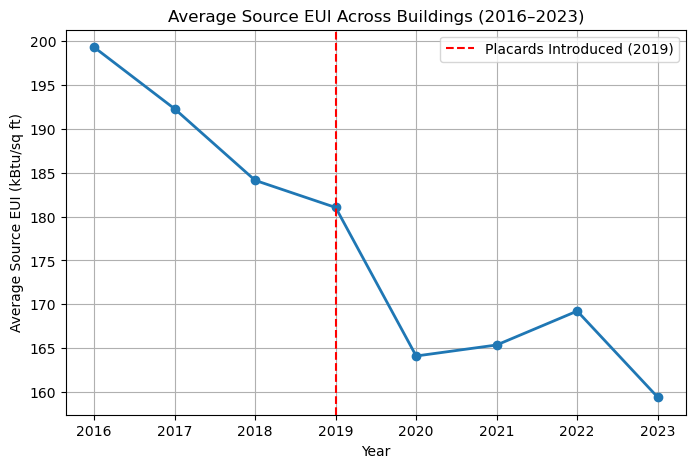

In [12]:
# annual average Source EUI across 8 years buildings (2016-2023)
mean_source = source_eui.mean(axis=0)

plt.figure(figsize=(8, 5))
plt.plot(mean_source.index, mean_source.values, marker="o", linewidth=2)
plt.axvline(x=2019, color="red", linestyle="--", label="Placards Introduced (2019)")
plt.title("Average Source EUI Across Buildings (2016–2023)")
plt.xlabel("Year")
plt.ylabel("Average Source EUI (kBtu/sq ft)")
plt.legend()
plt.grid(True)
plt.show()

We could see a constant declining trend for the average Source EUI in 8 years buildings, but the tendency is decelerated after 2019, with a smaller drop in source eui in 2021. The average level of source eui then keeps low, with some fluctuations up in 2022. The line looks as a concave up curve.
The constant decreasing tendency could because of the technological improvement in energy usage of buildings, since source eui includes losses from generation, transmission, & distribution. The decreasing reduce trend could because the limits or bottleneck of technology (?).

### 2.3: Electricity Use (kBtu)

In [13]:
# Electricity Use over 8-years buildings (2016-2023)
elec_use = pivot_energy_metric(
    metric_col="Electricity Use (kBtu)", input_df=energy_data
)
print(elec_use.shape)
elec_use.head()

(1259, 8)


Data Year,2016,2017,2018,2019,2020,2021,2022,2023
ID,,,,,,,,
100001,21387596.6,21338109.0,20125763.9,19078781.5,18515849.3,18651203.3,16795066.2,19177355.6
100068,6972237.8,6748789.0,5911184.2,6433462.5,4817089.3,8553112.9,8354489.4,5600060.5
100179,25863669.7,24796461.0,24686396.6,21144112.8,25103817.1,23712134.1,15191302.2,23884419.6
100346,1278084.0,1533291.0,1702792.7,1592697.7,1612176.8,2870150.5,1593052.3,1331687.9
100375,95234.4,541310.0,608857.8,599566.9,650252.2,692864.6,799196.2,701909.8


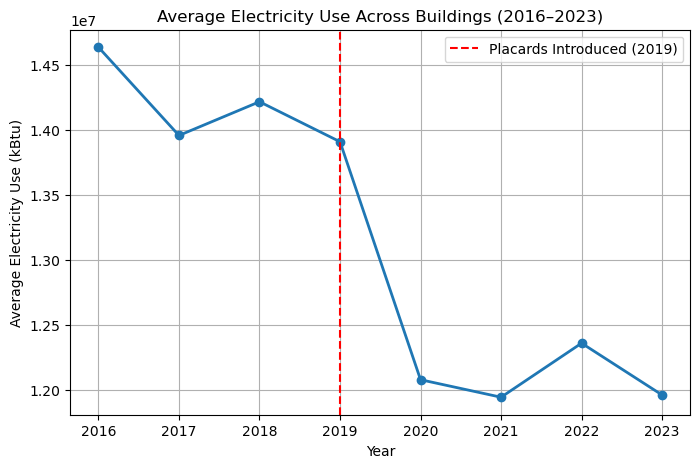

In [14]:
# annual average Electricity Use across buildings appear in 2016-2023
mean_elec = elec_use.mean(axis=0)

plt.figure(figsize=(8, 5))
plt.plot(mean_elec.index, mean_elec.values, marker="o", linewidth=2)
plt.axvline(x=2019, color="red", linestyle="--", label="Placards Introduced (2019)")
plt.title("Average Electricity Use Across Buildings (2016–2023)")
plt.xlabel("Year")
plt.ylabel("Average Electricity Use (kBtu)")
plt.legend()
plt.grid(True)
plt.show()

The main trend after 2016 is a low level of electricity use. 

### 2.4: GHG Intensity (kg CO2e/sq ft)

In [15]:
# GHG Intensity over 8-years buildings (2016-2023)
ghg_intensity = pivot_energy_metric(
    metric_col="GHG Intensity (kg CO2e/sq ft)", input_df=energy_data
)
print(ghg_intensity.shape)
ghg_intensity.head()

(660, 8)


Data Year,2016,2017,2018,2019,2020,2021,2022,2023
ID,,,,,,,,
100068,14.6,13.9,11.2,12.0,8.3,12.9,13.9,10.4
100375,1.7,6.2,4.7,4.5,5.8,5.4,5.4,5.9
100448,13.3,7.8,11.8,11.4,8.3,7.9,12.0,11.0
100485,4.6,4.7,5.8,5.8,5.6,5.3,5.7,5.1
101030,7.9,6.8,6.7,6.4,5.4,4.7,5.0,4.9


Overall, it shows a constant decreasing trend. As the buildings in this subset is mainly offices, it could find explanation in economic situation and unemployment.

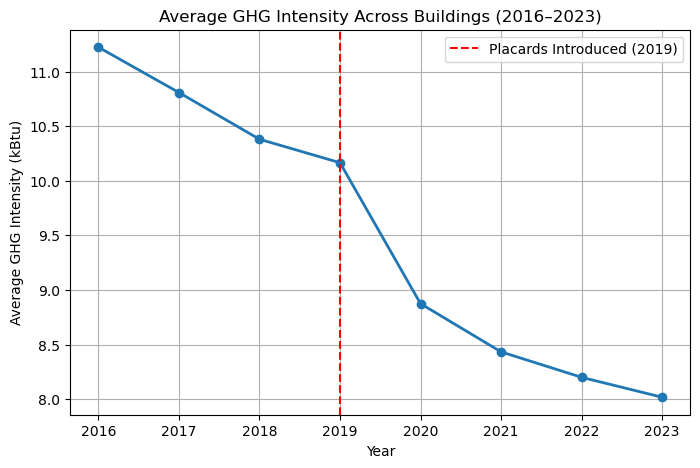

In [16]:
# annual average GHG Intensity across buildings appear in 2016-2023
mean_ghg = ghg_intensity.mean(axis=0)

plt.figure(figsize=(8, 5))
plt.plot(mean_ghg.index, mean_ghg.values, marker="o", linewidth=2)
plt.axvline(x=2019, color="red", linestyle="--", label="Placards Introduced (2019)")
plt.title("Average GHG Intensity Across Buildings (2016–2023)")
plt.xlabel("Year")
plt.ylabel("Average GHG Intensity (kBtu)")
plt.legend()
plt.grid(True)
plt.show()

The decreasing pattern after 2019 is quite visible. Similar pattern as before three key metrics.

## Section 3: Explore the Year-over-Year change (deltas) of Key energy metrics

The original raw data of key metrics of energy performance is not quite helpful because of the large variability and scope. We will then turn to focus on the deltas of energy metrics per building and see the trend of deltas over time.

Then draw the visualizations for the building-levels deltas of Site EUI. 
We use the visualization helper function in utils/delta_plot to create side-by-side plots. It assumes the function plot_building_energy_deltas is loaded in.

The three plots are respectively (from left to right): 
- **left: average absolute delta of Site EUI over year**,
- **middle: absolute deltas of Site EUI over year in building-levels**,
- **right: cumulative absolute deltas of Site EUI over year in building-levels**.


Absolute deltas of Site EUI over year in building-levels are not readable. Because the scale of mean trend is fixed into the fluctuated building-levels graph, the decreasing gap in 2020 looks much smaller than in the average delta graph. The cumulative deltas of Site EUI over year in building-level is more informative as all the building start off from 0, and we can see the later changes of Site EUI with respect to the baseline (2014).

### 3.1: Site EUI (kBtu/sq ft)

In [18]:
from plot_utils import plot_building_energy_deltas, plot_mean_cumulative_changes

This section we apply the visualization helper function in utils/plot_utils. The function plot_building_energy_deltas generates the dataframe with year-over-year change for visualization and the cumulative change.

The average deltas show a similar trend to the average site EUI in previous section. For the middle and right graph, the spread of the thin lines reflects variability — some buildings improved significantly, while others worsened. Though not every building improved, the average trend and cumulative trajectory indicate a net positive effect, amplified temporarily by the pandemic but sustained afterward.

(<Figure size 1800x600 with 3 Axes>,
 array([<Axes: title={'center': 'Average Year-over-Year Δ Site EUI'}, xlabel='Data Year', ylabel='Δ Site EUI'>,
        <Axes: title={'center': 'Year-over-Year Δ Site EUI per Building'}, xlabel='Data Year', ylabel='Δ Site EUI'>,
        <Axes: title={'center': 'Cumulative Δ Site EUI per Building (from 2016)'}, xlabel='Data Year', ylabel='Δ Site EUI'>],
       dtype=object))

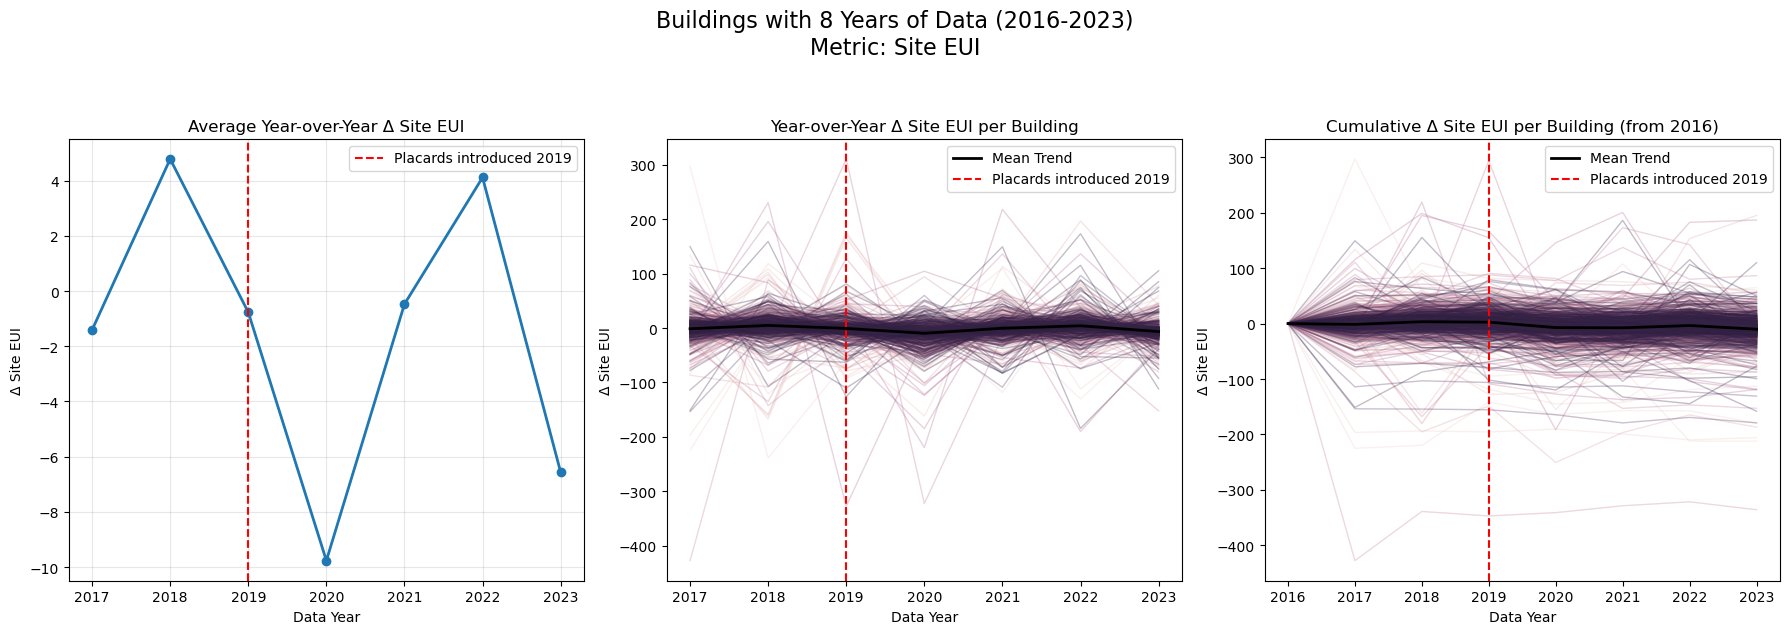

In [19]:
# The Site EUI visualization for buildings 8 years (2016-2023)
plot_building_energy_deltas(
    site_eui, metric_name="Site EUI", start_year=2016, end_year=2023
)

### 3.2: Source EUI (kBtu/sq ft)

(<Figure size 1800x600 with 3 Axes>,
 array([<Axes: title={'center': 'Average Year-over-Year Δ Source EUI'}, xlabel='Data Year', ylabel='Δ Source EUI'>,
        <Axes: title={'center': 'Year-over-Year Δ Source EUI per Building'}, xlabel='Data Year', ylabel='Δ Source EUI'>,
        <Axes: title={'center': 'Cumulative Δ Source EUI per Building (from 2016)'}, xlabel='Data Year', ylabel='Δ Source EUI'>],
       dtype=object))

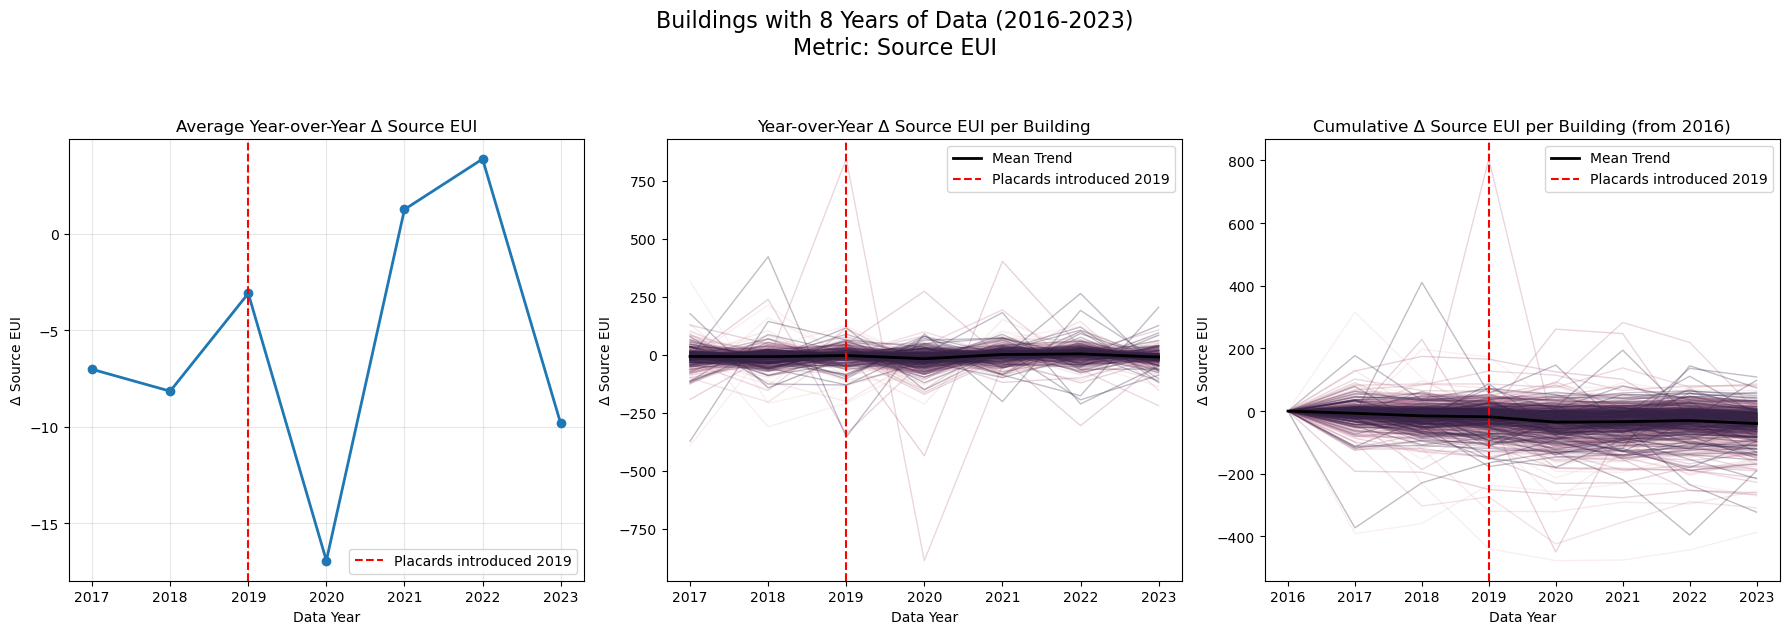

In [20]:
# The Source EUI visualization for buildings 8 years (2016-2023)
plot_building_energy_deltas(
    source_eui, metric_name="Source EUI", start_year=2016, end_year=2023
)

The overall trend of source eui is decreasing, as from the cumulative source eui by building-level graphs we could clearly see the more concentrated areas of buildings with negative deltas after 2019.

### 3.3: Electricity Use (kBtu)

(<Figure size 1800x600 with 3 Axes>,
 array([<Axes: title={'center': 'Average Year-over-Year Δ Electricity Use'}, xlabel='Data Year', ylabel='Δ Electricity Use'>,
        <Axes: title={'center': 'Year-over-Year Δ Electricity Use per Building'}, xlabel='Data Year', ylabel='Δ Electricity Use'>,
        <Axes: title={'center': 'Cumulative Δ Electricity Use per Building (from 2016)'}, xlabel='Data Year', ylabel='Δ Electricity Use'>],
       dtype=object))

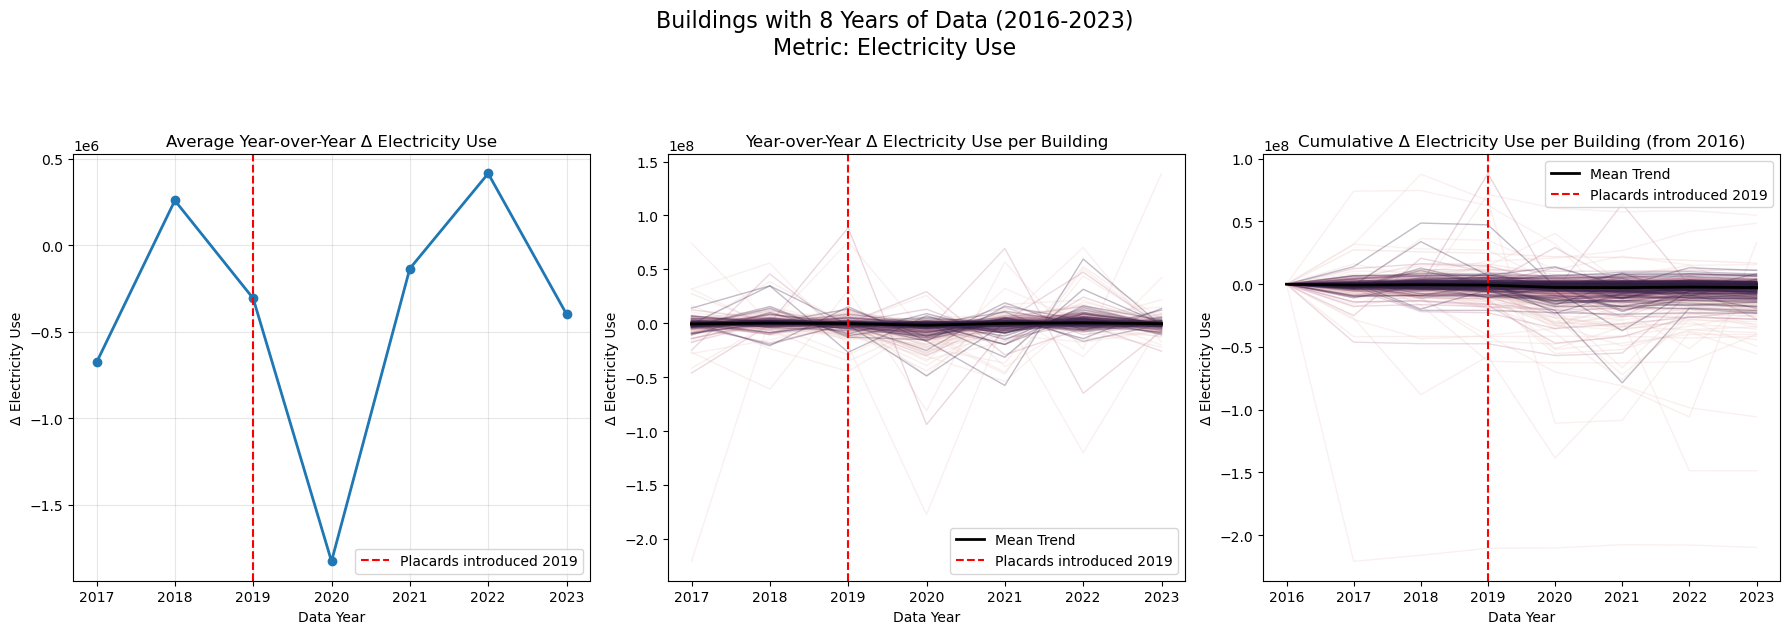

In [21]:
# The Electricity Use visualization for buildings 8 years (2016-2023)
plot_building_energy_deltas(
    elec_use, metric_name="Electricity Use", start_year=2016, end_year=2023
)

Similar pattern as Source EUI.

### 3.4:  GHG Intensity (kg CO2e/sq ft)

(<Figure size 1800x600 with 3 Axes>,
 array([<Axes: title={'center': 'Average Year-over-Year Δ GHG Intensity'}, xlabel='Data Year', ylabel='Δ GHG Intensity'>,
        <Axes: title={'center': 'Year-over-Year Δ GHG Intensity per Building'}, xlabel='Data Year', ylabel='Δ GHG Intensity'>,
        <Axes: title={'center': 'Cumulative Δ GHG Intensity per Building (from 2016)'}, xlabel='Data Year', ylabel='Δ GHG Intensity'>],
       dtype=object))

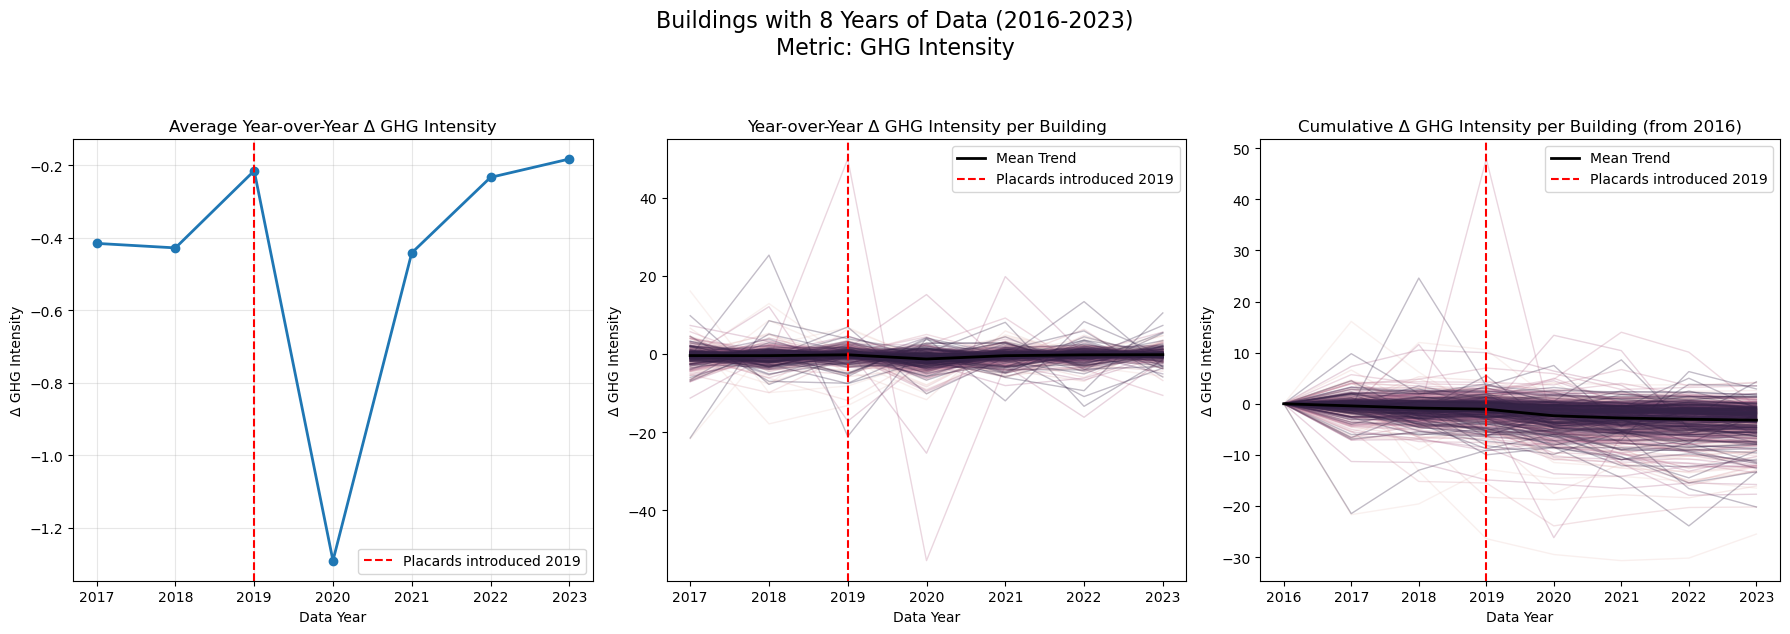

In [22]:
# The GHG Intensity visualization for buildings 8 years (2016-2023)
plot_building_energy_deltas(
    ghg_intensity, metric_name="GHG Intensity", start_year=2016, end_year=2023
)

GHG Intensity has more fluctuation in 10 years buildings comparing to the three metrics above. But the average absolute deltas of GHG Intensity shows a huge gap in 2020, with sharp decrease in greenhouse gasses after 2019. The cumulative change-from-baseline graphs both shows a decreasing pattern, with some buildings' data fluctuated but most of the lines are gathered under the net negative effect side.

## Section 4: Explore the Year-over-Year percentage change (% deltas) of Key energy metrics

The absolute deltas is not helpful to analyze and see difference. We then generate a more descriptive dataset with percentage change of energy use over time and compare the difference before and after 2019. A graph we will use is cumulative change-from-baseline chart, to show the percentage-change-from-baseline. It makes it easier to see the change over time for each line.

It assumes there's a helper function plot_mean_cumulative_changes in utils/plot_utils.py.

In [23]:
import numpy as np

In [25]:
# Compute year-over-year % change per building (row-wise)
site_eui_pct = site_eui.pct_change(axis=1) * 100
source_eui_pct = source_eui.pct_change(axis=1) * 100
elec_use_pct = elec_use.pct_change(axis=1) * 100
elec_use_pct.replace([np.inf, -np.inf], 0)
ghg_intensity_pct = ghg_intensity.pct_change(axis=1) * 100

metrics = {
    "Site EUI": site_eui_pct,
    "Source EUI": source_eui_pct,
    "Electricity Use": elec_use_pct,
    "GHG Intensity": ghg_intensity_pct,
}

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Cumulative % Change from Baseline (2016-2023)'}, xlabel='Year', ylabel='Cumulative % Change from Baseline'>)

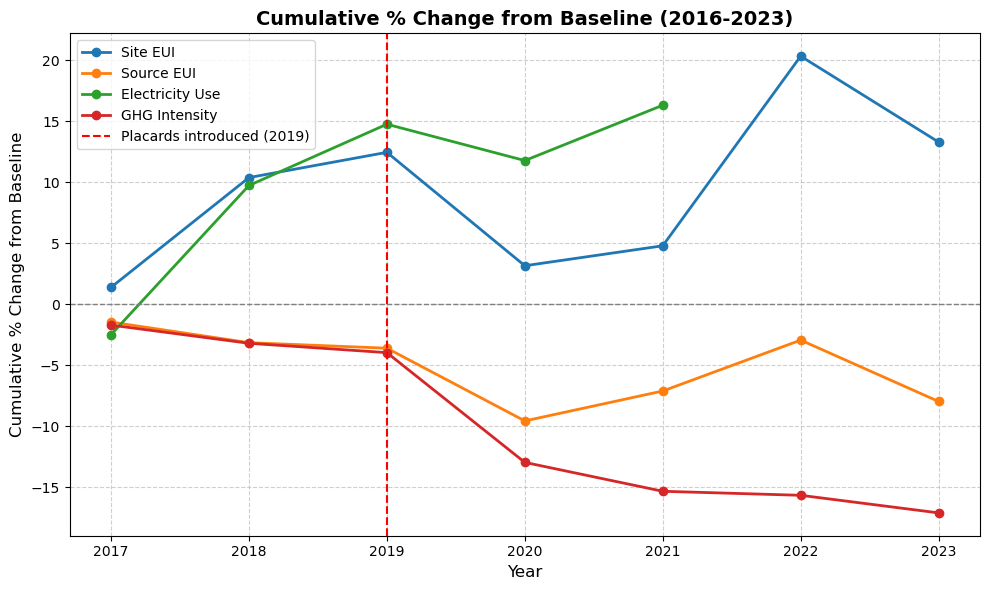

In [26]:
plot_mean_cumulative_changes(metrics, 2016, 2023)

As from the two change-from-baseline chart, we could see most of the energy metrics shows a declining trend after the introduction of Chicago Energy Ratings Placards system in 2019. The % Change of Electricity Use and Site EUI keep positive after 2019, with a small drop in 2020 then recover to higher level.     

For buildings in 8 years subset, they are mainly multifamily housing, in which the electricity use and on-site energy consumed should remain high even after COVID as people are staying at home.

## Section 5: Conclusions and Future directions

**Conclusions:** All energy metrics show energy usage drop after 2019, but the extent of decline and the duration differs. The subsets of 8 years building show more fluctuations in energy usage, mainly with recovering and increasing energy use after 2020. It could be due to more buildings and property types included in the subset, leading to higher variability with larger sample size. 

**Future directions:**
We can set a constant name for each building ID to make the dataset more readable with the property name, do the analysis on property types of buildings to see how it affects the energy usage across the longitudinal time scale. We can group the year-over-year changes by property types with different colors and legend, to see if the building type influence the trend and specifically what type of buildings is more affected by the placards system and drop energy usage.

 **Covid-19 effect:**
 Moreover, an important problem we need to address is the coincidence of COVID effect with the Placards system effect in this Chicago Energy Benchmarking data. It's a bit hard to distinguish whether the energy drop is the result of Chicago Energy Ratings Placards System or the result of pandemic, or does pandemic intensifies the effect of placards. We can find a type of building not quite influenced by covid, probably schools because the effect should recover after COVID, and analyze the year-over-year change specifically on this subset.